# Introduction
Hi! I am **Mark Wilson Mendoza**, and this project explores my **Spotify Streaming History** using **Python**.  
My goal is to uncover insights about my personal listening habits and practice querying data using **SQL**.  
The dataset comes from Spotify's Extended Streaming History, which you can request from their [Privacy Settings](https://www.spotify.com/us/account/privacy/).  
To get your own data:
1. Scroll to **Download your data** 
2. Tick the box for **Extended Streaming History**
3. Submit your request and wait for the download link via email (mine arrived after ~3 days)

The Spotify data includes both your audio and video streaming activity, along with a PDF file that describes the provided files.  
In this project, the dataset covers streams from **December 13, 2021 to June 18, 2025**  
**Here is an example of one song streaming data:**
![](images/song_stream_data.png)  
**The following table explains the technical data:**
![](images/column_description_0.png)
![](images/column_description_1.png)

Before the analysis, we need to install and import some essential libraries:
- warnings (optional) - suppress runtime warnings
- json - Load data from Spotify's JSON files
- pandas - Data wrangling and manipulation
- matplotlib - Static data visualization
- plotly - Interactive plots
- sqlalchemy and sqlite3 - Relational database and SQL integration

In [1]:
import warnings
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sqlalchemy import create_engine
import sqlite3

warnings.filterwarnings("ignore")

# Loading and Cleaning the Data
Since Spotify splits the extended streaming history into multiple JSON files, the first step is to load and combine them into a single dataset.  
We can then inspect the dataset and see the **column names**.

In [2]:
# Opens the JSON files and loads them into pandas DataFrames
with open("data/Streaming_History_Audio_2021-2024_0.json", encoding="utf-8") as a:
    a_data = json.load(a)

with open("data/Streaming_History_Audio_2024-2025_1.json", encoding="utf-8") as b:
    b_data = json.load(b)

with open("data/Streaming_History_Audio_2025_2.json", encoding="utf-8") as c:
    c_data = json.load(c)
    
a_data = pd.json_normalize(a_data)
b_data = pd.json_normalize(b_data) # Normalize the JSON data into a flat table
c_data = pd.json_normalize(c_data)

df = pd.concat([a_data, b_data, c_data], ignore_index=True) # Combines the DataFrames into one
print(df.columns)

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode'],
      dtype='object')


The timestamps in the dataset are in UTC, so we need to convert them to **Philippine Time (UTC+8)** for a better time analysis.  
We also only focus on the most relevant columns:  
- time
- platform
- duration played
- song title
- artist name
- album name
- skipped status

In [3]:
df["ts"] = pd.to_datetime(df["ts"], format="ISO8601", utc=True) # Converts the 'ts' column to datetime format
df["ts"] = df["ts"].dt.tz_convert("Asia/Manila") # Converts the timezone to Asia/Manila

cleaned_df = df[["ts", "platform", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name", "skipped"]]
cleaned_df.columns = ["time", "platform", "ms_played", "song", "artist", "album", "skipped"]

cleaned_df = cleaned_df.dropna().reset_index() # Drops rows with any NaN values
cleaned_df.head(10)

,index,time,platform,ms_played,song,artist,album,skipped
0,0,2021-12-13 22:29:52+08:00,Windows 10 (10.0.19043; x64),198053,The Feels,TWICE,Formula of Love: O+T=<3,False
1,1,2021-12-13 22:33:07+08:00,Windows 10 (10.0.19043; x64),194600,SCIENTIST,TWICE,Formula of Love: O+T=<3,False
2,2,2021-12-13 22:36:39+08:00,Windows 10 (10.0.19043; x64),210573,Alcohol-Free,TWICE,Taste of Love,False
3,3,2021-12-13 22:40:04+08:00,Windows 10 (10.0.19043; x64),205493,I CAN'T STOP ME,TWICE,Eyes Wide Open,False
4,4,2021-12-13 22:44:04+08:00,Windows 10 (10.0.19043; x64),208240,What is Love,TWICE,Summer Nights,False
5,5,2021-12-13 22:47:38+08:00,Windows 10 (10.0.19043; x64),213880,FANCY,TWICE,FANCY YOU,False
6,6,2021-12-13 22:51:06+08:00,Windows 10 (10.0.19043; x64),206866,Feel Special,TWICE,Feel Special,False
7,7,2021-12-13 22:54:30+08:00,Windows 10 (10.0.19043; x64),204167,CRY FOR ME,TWICE,CRY FOR ME,False
8,8,2021-12-13 22:57:57+08:00,Windows 10 (10.0.19043; x64),176160,ICON,TWICE,Formula of Love: O+T=<3,False
9,9,2021-12-13 23:04:25+08:00,Windows 10 (10.0.19043; x64),219386,MOONLIGHT,TWICE,Formula of Love: O+T=<3,False


# Top 10 Artists
Let's see which **artists** I listened to the most

In [4]:
top_artists = cleaned_df["artist"].value_counts().head(10) # Gets the top 10 artists
top_artists = top_artists.reset_index() # Resets the index for better readability
print("Top 10 Artists:\n", top_artists)

Top 10 Artists:
           artist  count
0     Cup of Joe   1675
1          TWICE   1585
2   Zack Tabudlo    907
3        Ben&Ben    904
4    The Ridleys    768
5            WWE    674
6           mrld    643
7           BUZZ    594
8  Martti Franca    586
9           BINI    574


**Cup of Joe** takes the top spot, followed by **TWICE**, both surpassed 1500 streams.

Below is a clear visualization of my **Top 10 most streamed artists**:

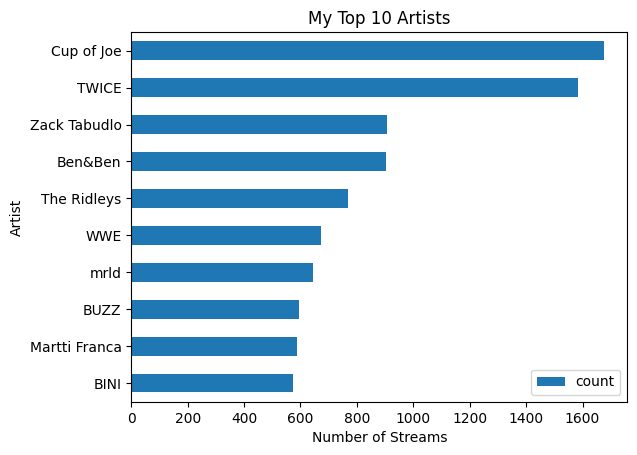

In [5]:
# Plots the top 10 artists using Matplotlib
top_artists.sort_values(by="count", ascending=True).plot(kind="barh", x="artist", y="count")
plt.title("My Top 10 Artists")
plt.xlabel("Number of Streams")
plt.ylabel("Artist")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    top_artists,
    x=top_artists["count"].sort_values(ascending=True),
    y=top_artists["artist"].sort_index(ascending=False),
    title="My Top 10 Artists",
    labels={"x" : "Artist", "y" : "Number of Streams"},
    orientation="h"
)

fig.show()

This bar graph highlights the gap between the top two artists and the rest. It shows that **Cup of Joe** and **TWICE** dominated my listeing habits.

Now let's explore my **listening habits over time** for my two most streamed artists: Cup of Joe and TWICE.

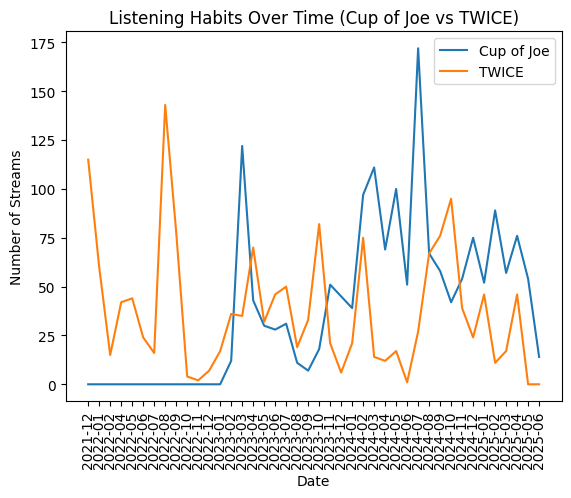

In [6]:
CoJ_streams = cleaned_df[cleaned_df["artist"] == "Cup of Joe"]
CoJ_streams["date"] = CoJ_streams["time"].dt.to_period("M").astype(str)
CoJ_counts = CoJ_streams["date"].value_counts().sort_index()

TW_streams = cleaned_df[cleaned_df["artist"] == "TWICE"]
TW_streams["date"] = TW_streams["time"].dt.to_period("M").astype(str)
TW_counts = TW_streams["date"].value_counts().sort_index()

all_dates = sorted(set(CoJ_counts.index).union(set(TW_counts.index)))

CoJ_aligned_dates = CoJ_counts.reindex(all_dates, fill_value=0).reset_index()
TW_aligned_dates = TW_counts.reindex(all_dates, fill_value=0).reset_index()

plt.plot(CoJ_aligned_dates["date"], CoJ_aligned_dates["count"], label="Cup of Joe")
plt.plot(TW_aligned_dates["date"], TW_aligned_dates["count"], label="TWICE")
plt.title("Listening Habits Over Time (Cup of Joe vs TWICE)")
plt.xlabel("Date")
plt.ylabel("Number of Streams")
plt.xticks(rotation=90)
plt.legend()
plt.show()

The line graph above compares their monthly stream counts, which highlights which artist I've listened to the most at different points in time.

# Top 10 Albums
Now, let's explore which **albums** I've listened to the most.

In [7]:
top_albums = cleaned_df["album"].value_counts()
top_albums = top_albums.reset_index()

# Get the artist for each album in top_albums
album_to_artist = cleaned_df.drop_duplicates(subset=["album"])[["artist", "album"]].set_index("album")["artist"]
top_albums["artist"] = top_albums["album"].map(album_to_artist)
top_albums = top_albums[["artist", "album", "count"]]
print("Top 10 Albums:\n", top_albums.head(10))

Top 10 Albums:
            artist                              album  count
0            Hale                               Hale    349
1     The Ridleys  Reflections on Moonlight & Poetry    301
2    Zack Tabudlo                 3rd Time’s A Charm    287
3      Cup of Joe                        Estranghero    272
4      Cup of Joe                       Patutunguhan    260
5    Zack Tabudlo                            Episode    260
6           TWICE                        BETWEEN 1&2    208
7      Bruno Mars               Doo-Wops & Hooligans    207
8  Unique Salonga                            Grandma    200
9    IV Of Spades                      CLAPCLAPCLAP!    198


Overall, **Hale (album)** by **Hale (artist)** is my most streamed album.  
Interestingly, both **Zack Tabudlo** and **Cup of Joe** appear twice in the top 10, this shows my music taste and go-to albums.

# Top 10 Songs
These are the songs I've listed to the most.

In [8]:
top_songs = cleaned_df["song"].value_counts()
top_songs = top_songs.reset_index()

song_to_artist = cleaned_df.drop_duplicates(subset=["song"])[["artist", "song"]].set_index("song")["artist"]
top_songs["artist"] = top_songs["song"].map(song_to_artist)
top_songs = top_songs[["artist", "song", "count"]]
print("Top 10 Songs:\n", top_songs.head(10))

Top 10 Songs:
            artist                      song  count
0      Cup of Joe               Estranghero    272
1      Cup of Joe                Misteryoso    197
2      Cup of Joe                    Tingin    196
3  Up Dharma Down                   Tadhana    191
4      Cup of Joe                 Sinderela    176
5      Lola Amour                    Fallen    168
6            Maki                     Dilaw    167
7      Cup of Joe               Wag Na Lang    167
8            mrld               Ikaw Pa Rin    165
9   Martti Franca  Things She'll Never Know    163


**Cup of Joe** once again takes the top spot.  
They also appear **five times** in the Top 10.  
This proves why they're my most streamed artist.

# Top 10 Skipped Songs
Let's now look at my Top 10 skipped songs

In [9]:
skipped_songs = cleaned_df[cleaned_df["skipped"] == True]
skipped_song_counts = skipped_songs["song"].value_counts().head(10) # Gets the top 10 skipped songs
skipped_song_counts = skipped_song_counts.reset_index()

song_to_artist = skipped_songs.drop_duplicates(subset=["song"])[["artist", "song"]].set_index("song")["artist"]
skipped_song_counts["artist"] = skipped_song_counts["song"].map(song_to_artist)
skipped_song_counts = skipped_song_counts[["artist", "song", "count"]]

print("Top 10 Skipped Songs:\n", skipped_song_counts.head(10))

Top 10 Skipped Songs:
              artist         song  count
0              Maki        Dilaw     77
1        Cup of Joe  Estranghero     70
2        Cup of Joe   Misteryoso     62
3        Cup of Joe       Tingin     62
4        Lola Amour       Fallen     51
5        Cup of Joe  Wag Na Lang     51
6  Healy After Dark         Isip     47
7    Up Dharma Down      Tadhana     46
8            NOBITA    Ikaw Lang     44
9              MKTO      Classic     43


The song **Dilaw** by **Maki** is at the top of my most skipped songs. 
But what's intersting about this is that some songs here also appear in my Top 10 most streamed songs.  
This might suggest that even though I stream these songs a lot, I also tend to skip them occasionally, maybe due to being overplayed.

To prepare the dataset for SQL queries, we need to separate the data into:
- **Artists**
- **Albums**
- **Songs**  

The next few steps extract the unique values for each of the ones above.  
This step is needed in designing a relational database schema later on.

In [10]:
cleaned_df_copy = cleaned_df.copy() # Creates a copy of the cleaned DataFrame for further analysis

In [11]:
# Creates a DataFrame with unique artists and assigns a unique ID to each artist
streamed_artists = pd.DataFrame(cleaned_df_copy["artist"].unique(), columns=["artist"]) # Creates a DataFrame with unique artists
streamed_artists["artist_id"] = streamed_artists.index + 1 # Assigns a unique ID to each artist
streamed_artists = streamed_artists.iloc[:, [1, 0]] # Reorders the columns to have artist_id first
streamed_artists.head(10)

,artist_id,artist
0,1,TWICE
1,2,NiziU
2,3,J.Y. Park
3,4,(G)I-DLE
4,5,Stray Kids
5,6,GOT7
6,7,STAYC
7,8,K/DA
8,9,Seungmin
9,10,ITZY


In [12]:
# Creates a DataFrame with unique songs and assigns a unique ID to each song
streamed_music = pd.DataFrame(cleaned_df_copy["song"].unique(), columns=["song"]) # Creates a DataFrame with unique songs
streamed_music["song_id"] = streamed_music.index + 1 # Assigns a unique
streamed_music = streamed_music.iloc[:, [1, 0]] # Reorders the columns to have song_id first
streamed_music.head(10)

,song_id,song
0,1,The Feels
1,2,SCIENTIST
2,3,Alcohol-Free
3,4,I CAN'T STOP ME
4,5,What is Love
5,6,FANCY
6,7,Feel Special
7,8,CRY FOR ME
8,9,ICON
9,10,MOONLIGHT


In [13]:
# Creates a DataFrame with unique albums and assigns a unique ID to each album
streamed_albums = pd.DataFrame(cleaned_df_copy["album"].unique(), columns=["album"]) # Creates a DataFrame with unique albums
streamed_albums["album_id"] = streamed_albums.index + 1 # Assigns a unique ID to each album
streamed_albums = streamed_albums.iloc[:, [1, 0]] # Reorders the columns to have album_id first
streamed_albums.head(10)

,album_id,album
0,1,Formula of Love: O+T=<3
1,2,Taste of Love
2,3,Eyes Wide Open
3,4,Summer Nights
4,5,FANCY YOU
5,6,Feel Special
6,7,CRY FOR ME
7,8,Doughnut
8,9,Perfect World
9,10,Kura Kura


# Monthly Streaming Activity
Let's look at the change of my **overall listening activity** by month.

In [14]:
# Returns the number of streams per month
cleaned_df_copy["month"] = cleaned_df_copy["time"].dt.month
monthly_counts = cleaned_df_copy["month"].value_counts().sort_index() # Counts the number of streams per month
monthly_df = monthly_counts.reset_index()
monthly_df.head()

,month,count
0,1,2223
1,2,3549
2,3,3955
3,4,3540
4,5,3840


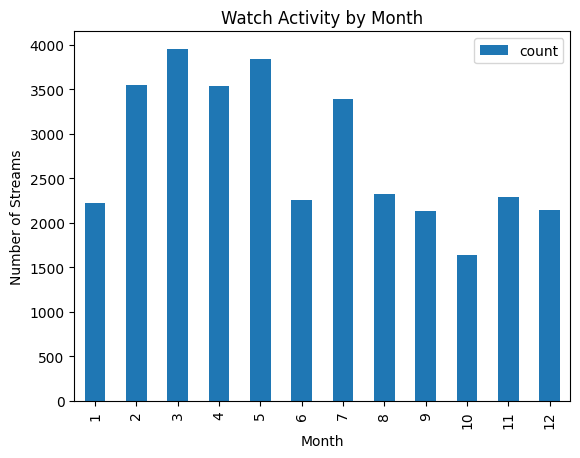

In [15]:
# Use Matplotlib to plot the all-time streams by month
monthly_df.plot(kind="bar", x="month", y="count")
plt.title("Watch Activity by Month")
plt.xlabel("Month")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    monthly_df,
    x="month",
    y="count",
    title="Watch Activity by Month",
    labels={"month": "Month", "count": "Number of Streams"}
)

fig.show()

The chart shows that **March** has the highest stream counts across the dataset.  
But is that a consistent pattern across years? Or maybe there is a single March that I streamed the most?

# Weekly Streaming Activity
Let's zoom in further and explore my **weekly streaming data**.

In [16]:
# Returns the number of streams per month and year
cleaned_df_copy["month_year"] = cleaned_df_copy["time"].dt.to_period("M").astype(str) # Creates a new column for month and year
month_year_counts = cleaned_df_copy["month_year"].value_counts().sort_index() # Counts the number of streams per month and year
month_year_df = month_year_counts.reset_index()
month_year_df.head(10)

,month_year,count
0,2021-12,164
1,2022-01,284
2,2022-02,341
3,2022-03,99
4,2022-04,167
5,2022-05,519
6,2022-06,403
7,2022-07,274
8,2022-08,516
9,2022-09,584


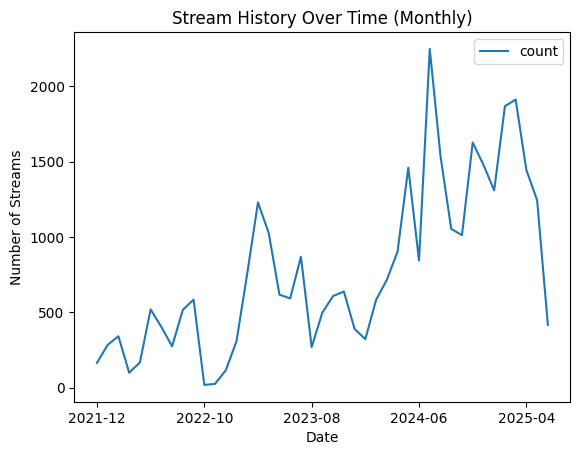

In [17]:
# Use Matplotlib to plot the all-time streams by month and year
month_year_df.plot(kind="line", x="month_year", y="count")
plt.title("Stream History Over Time (Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.line(
    month_year_df,
    x="month_year",
    y="count",
    title="Stream History Over Time (Monthly)",
    labels={"month_year" : "Date", "count" : "Number of Streams"},
    markers=True
)

fig.show()

Surprisingly, even though March has the highest overall streams, the **single most active** week was in **July 2024**.  
This deeper breakdown conveys more insight into specific period of streaming.

# Hourly Streaming Activity
Now that we've seen how much I listen to music, let's explore when I'm most active.

In [18]:
# Returns the number of streams per hour
cleaned_df_copy["hour"] = cleaned_df_copy["time"].dt.hour
hourly_counts = cleaned_df_copy["hour"].value_counts().sort_index() # Counts the number of streams per hour
hourly_df = hourly_counts.reset_index()
hourly_df.head()

,hour,count
0,0,162
1,1,38
2,2,9
3,3,5
4,4,15


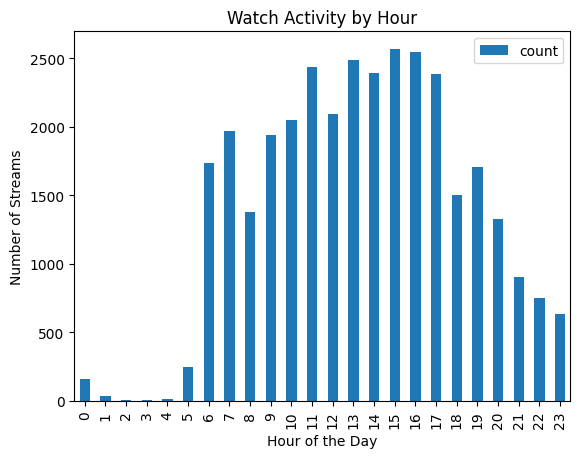

In [19]:
# Use Matplotlib to plot the all-time streams by hour
hourly_df.plot(kind="bar", x="hour", y="count")
plt.title("Watch Activity by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    hourly_df,
    x="hour",
    y="count",
    title="Watch Activity by Hour",
    labels={"hour" : "Hour of Day", "count" : "Number of Streams"}
)
fig.show()

The graph above shows that my **peak listening hours** are between **11AM and 5PM**, probably during work or study hours.

# Saving to a Database
Next, we store our structured data into an **SQLite database**.
The following tables were created for future SQL analysis:
- `streaming_history` - Main streaming data
- `streamed_artists` - Unique list of artists
- `streamed_music` - Unique list of tracks
- `streamed_albums` - Unique list of albums

In [ ]:
# Creates a SQLite database and saves the cleaned DataFrame and the streamed artists, music, and albums to it
engine = create_engine("sqlite:///exported/streaming_history.db") # Creates a SQLite database
cleaned_df.to_sql("streaming_history", con=engine, if_exists="replace", index=False) # Saves the cleaned DataFrame to the database
streamed_artists.to_sql("streamed_artists", con=engine, if_exists="replace", index=False) # Saves the streamed artists to the database
streamed_music.to_sql("streamed_music", con=engine, if_exists="replace", index=False) # Saves the streamed music to the database
streamed_albums.to_sql("streamed_albums", con=engine, if_exists="replace", index=False) # Saves the streamed albums to the database

2583

# SQL Queries
Since **Cup of Joe** was one of my most streamed artists, here is a sample query to fetch all streams from therm.

In [21]:
# Sample query to fetch data from the SQLite database
conn = sqlite3.connect("data/streaming_history.db") # Connects to the SQLite database
cursor = conn.cursor()

cursor.execute("""
    SELECT * 
    FROM streaming_history
    WHERE artist = "Cup of Joe"
    LIMIT 10;
""")
rows = cursor.fetchall() # Fetches the results of the query
for row in rows:
    print(row) # Prints each row of the results

conn.close() # Closes the database connection

(4394, '2023-02-26 09:07:32.000000', 'windows', 186584, 'Estranghero', 'Cup of Joe', 'Estranghero', 0)
(4396, '2023-02-26 09:10:42.000000', 'windows', 186471, 'Estranghero', 'Cup of Joe', 'Estranghero', 0)
(4397, '2023-02-26 09:15:28.000000', 'windows', 252459, 'Ikaw Pa Rin Ang Pipiliin Ko', 'Cup of Joe', 'Ikaw Pa Rin Ang Pipiliin Ko', 1)
(4398, '2023-02-26 09:15:29.000000', 'windows', 541, 'Estranghero', 'Cup of Joe', 'Estranghero', 1)
(4399, '2023-02-26 09:18:36.000000', 'windows', 186564, 'Estranghero', 'Cup of Joe', 'Estranghero', 0)
(4400, '2023-02-26 09:20:20.000000', 'windows', 103764, 'Ikaw Pa Rin Ang Pipiliin Ko', 'Cup of Joe', 'Ikaw Pa Rin Ang Pipiliin Ko', 1)
(4401, '2023-02-26 09:28:16.000000', 'windows', 475156, 'Estranghero', 'Cup of Joe', 'Estranghero', 0)
(4402, '2023-02-26 09:32:38.000000', 'windows', 261957, 'Ikaw Pa Rin Ang Pipiliin Ko', 'Cup of Joe', 'Ikaw Pa Rin Ang Pipiliin Ko', 0)
(4403, '2023-02-26 09:35:32.000000', 'windows', 149619, 'Sinderela', 'Cup of Joe', 

This query returns the **first 10** times I streamed a song by Cup of Joe, along with other details.